In [1]:
import baostock as bs   
import pandas as pd

In [ ]:
#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

In [ ]:
def download_data(date):
    bs.login()
    print('login respond error_code:'+lg.error_code)
    print('login respond  error_msg:'+lg.error_msg)
    # 获取指定日期的指数、股票数据
    stock_rs = bs.query_all_stock(date)
    stock_df = stock_rs.get_data()
    data_df = pd.DataFrame()
    for code in stock_df["code"]:
        print("Downloading :" + code)
        k_rs = bs.query_history_k_data_plus(code, "date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST", date, date)
        data_df = data_df.append(k_rs.get_data())
    bs.logout()
    #data_df.to_csv(r"data./demo_assignDayData.csv", encoding="gbk", index=False)
    #print(data_df)
    return data_df


In [7]:
def judge_kline_category(code, startdate, enddate):
    """判断证券在起止时间内的每日 K 线类别：阳线，阴线。
        :param code:证券代码
        :param startdate:起始日期
        :param enddate:截止日期
        :return:
    """
    login_result = bs.login()
    print(login_result.error_msg)
    # 获取股票日 K 线数据,adjustflag 复权状态(1：后复权， 2：前复权，3：不复权）
    rs = bs.query_history_k_data(code,"date,code,open,high,low,close,tradeStatus",\
                                 start_date=startdate,end_date=enddate,frequency="d", adjustflag="3")
    # 打印结果集
    result_list = []
    while (rs.error_code == '0') & rs.next():
        # 获取一条记录，将记录合并在一起
        result_list.append(rs.get_row_data())
    df_init = pd.DataFrame(result_list, columns=rs.fields)
    # 剔除停盘数据
    df_status = df_init[df_init['tradeStatus'] == '1']
    df_status['open'] = df_status['open'].astype(float)
    df_status['high'] = df_status['high'].astype(float)
    df_status['low'] = df_status['low'].astype(float)
    df_status['close'] = df_status['close'].astype(float)
    df_status['kline_category'] = df_status.apply(lambda x: judge_function(x.open, x.close), axis=1)
    df_status.to_csv('./df.csv')
    return df_status

def kline_application(df, N):
    """已知证券在起止时间内的每日 K 线类别：阳线，阴线。
        做如下统计：
        情景 1. 若证券股价连续 N 天下跌后出现大阳线，次日股价开盘上涨的次数
            （第 N+2 天）
        情景 2. 若证券股价连续 N 天上涨之后出现大阴线，次日股价开盘下跌的次数
            （第 N+2 天）
        :return:
    """
    daycounts = df.shape[0]
    df['kline_numb'] = [1 if x == 'positive' else 0 for x in
    df['kline_category']]
    df['scene'] = 0
    total_counts_1 = 0 # 计算情景 1 中证券股价连续 N 天下跌后出现大阳线的次数
    total_counts_1_sub = 0 # 计算情景 1 出现的次数
    total_counts_2 = 0 # 计算情景 2 中证券证券股价连续 N 天上涨之后出现大阴线的次数
    total_counts_2_sub = 0 # 计算情景 2 出现的次数
    for i in range(0, daycounts - N - 1):
        kline_numb_counts = 0
        for j in range(0, N):
            kline_numb_counts += df.iloc[i + j, 8]
            if kline_numb_counts == N and df.iloc[i + N, 8] == 0:
            # 表明该证券连续 N 天上涨后出 现了大阴线
                total_counts_2 += 1
                if df.iloc[i + N + 1, 2] < df.iloc[i + N, 5]:
                    total_counts_2_sub += 1
                    df.iloc[i + N, 9] = 2 # 表明这一天属于情景 2
    if kline_numb_counts == 0 and df.iloc[i + N, 8] == 1:
        # 表明该证券连续 N 天下跌后出现了大阳线
        total_counts_1 += 1
        if df.iloc[i + N + 1, 2] > df.iloc[i + N, 5]:
            total_counts_1_sub += 1
            df.iloc[i + N, 9] = 1 # 表明这一天属于情景 1
    df.to_csv('./df2.csv')
    print("证券代码：" + df['code'][0])
    print("证券股价连续 N 天下跌后出现大阳线的总次数：" +str(total_counts_1))
    print("若证券股价连续 N 天下跌后出现大阳线，次日股价开盘上涨的次数（第N+2 天）:" + str(total_counts_1_sub) + ",占比："+ str(total_counts_1_sub / total_counts_1))
    print("证券股价连续 N 天上涨之后出现大阴线的总次数：" +str(total_counts_2))
    print("若证券股价连续 N 天上涨之后出现大阴线，次日股价开盘下跌的次数（第N+2 天）:" + str(total_counts_2_sub) + ",占比："+ str(total_counts_2_sub / total_counts_2))
    return (total_counts_1, total_counts_1_sub, total_counts_2,total_counts_2_sub)

def judge_function(open, close):
    if open > close:
        return 'negative'
    else:
        return 'positive'


In [11]:
if __name__ == '__main__':
    code = "sz.002026"
    startdate = "2000-01-01"
    enddate = "2024-04-03"
    N = 5
    df = judge_kline_category(code, startdate, enddate)
    kline_application(df, N)

login success!
success


/var/folders/1g/k_5jcfzs6ldb71_4qj2936w00000gn/T/ipykernel_16991/3590870594.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_status['open'] = df_status['open'].astype(float)
/var/folders/1g/k_5jcfzs6ldb71_4qj2936w00000gn/T/ipykernel_16991/3590870594.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_status['high'] = df_status['high'].astype(float)
/var/folders/1g/k_5jcfzs6ldb71_4qj2936w00000gn/T/ipykernel_16991/3590870594.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

证券代码：sz.002026
证券股价连续 N 天下跌后出现大阳线的总次数：0


ZeroDivisionError: division by zero

In [12]:
import baostock as bs
import pandas as pd

#### 登陆系统 ####
lg = bs.login()
# 显示登陆返回信息
print('login respond error_code:'+lg.error_code)
print('login respond  error_msg:'+lg.error_msg)

#### 获取证券信息 ####
rs = bs.query_all_stock(day="2024-04-03")
print('query_all_stock respond error_code:'+rs.error_code)
print('query_all_stock respond  error_msg:'+rs.error_msg)

#### 打印结果集 ####
data_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    data_list.append(rs.get_row_data())
alstocks = pd.DataFrame(data_list, columns=rs.fields)

#### 结果集输出到csv文件 ####   
alstocks.to_csv("./all_stock.csv", encoding="gbk", index=False)


#### 登出系统 ####
bs.logout()

login success!
login respond error_code:0
login respond  error_msg:success
query_all_stock respond error_code:0
query_all_stock respond  error_msg:success
logout success!


In [17]:
#进保留上交所和深交所
alstocks = alstocks.loc[(alstocks.loc[:,'code'].str.startswith('sh')|alstocks.loc[:,'code'].str.startswith('sz')),:]


,code,tradeStatus,code_name
0,bj.430017,1,
1,bj.430047,1,
2,bj.430090,1,
3,bj.430139,1,
4,bj.430198,1,
...,...,...,...
5853,sz.399994,1,中证信息安全主题指数
5854,sz.399995,1,中证基建工程指数
5855,sz.399996,1,中证智能家居指数
5856,sz.399997,1,中证白酒指数


In [38]:
#查询股票行业
bs.login()
rs = bs.query_stock_industry()
industry_list = []
while (rs.error_code == '0') & rs.next():
    # 获取一条记录，将记录合并在一起
    industry_list.append(rs.get_row_data())
result = pd.DataFrame(industry_list, columns=rs.fields)
bs.logout()
result.head()


login success!
logout success!


,updateDate,code,code_name,industry,industryClassification
0,2024-03-18,sh.600000,浦发银行,银行,申万一级行业
1,2024-03-18,sh.600001,邯郸钢铁,,申万一级行业
2,2024-03-18,sh.600002,齐鲁石化,,申万一级行业
3,2024-03-18,sh.600003,ST东北高,,申万一级行业
4,2024-03-18,sh.600004,白云机场,交通运输,申万一级行业


In [24]:
result.industry.drop_duplicates()

0        银行
1          
4      交通运输
6        汽车
7       房地产
8      公用事业
10       钢铁
25       化工
27     非银金融
28     机械设备
33       传媒
34     国防军工
35     建筑装饰
37       通信
38       综合
41     休闲服务
42     医药生物
45     商业贸易
46     食品饮料
47     家用电器
58       电子
63     轻工制造
76     电气设备
84     农林牧渔
87      计算机
94     纺织服装
98     有色金属
108      采掘
287    建筑材料
Name: industry, dtype: object

In [162]:
result.loc[result.loc[:,'code']=='sz.002167',:]

,updateDate,code,code_name,industry,industryClassification
3134,2024-03-18,sz.002167,东方锆业,有色金属,申万一级行业


In [94]:
def get_industry_k_data(industry,startdate,enddate):
    """获得单个行业的所有股票数据
        :param industry:行业
        :param startdate:起始日期
        :param enddate:截止日期
        :return:
    """
    bs.login()
    print('login respond error_code:'+lg.error_code)
    print('login respond  error_msg:'+lg.error_msg)
    # 获取指定日期的指数、股票数据
    stock_rs = bs.query_stock_industry()
    industry_list = []
    while (stock_rs.error_code == '0') & stock_rs.next():
    # 获取一条记录，将记录合并在一起
        industry_list.append(stock_rs.get_row_data())
    stock_df = pd.DataFrame(industry_list, columns=rs.fields)
    code_list = stock_df.loc[stock_df.loc[:,'industry']== industry,'code'].tolist()

    stock_klist = []
    for code in code_list:
        print("Downloading :" + code)
        k_rs = bs.query_history_k_data_plus(code, "date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST", startdate, enddate)
        code_stocks = []
        while (k_rs.error_code == '0') & k_rs.next():
    # 获取一条记录，将记录合并在一起
            code_stocks.append(k_rs.get_row_data())
        stock_klist.extend(code_stocks)
    stock_df = pd.DataFrame(stock_klist,columns = k_rs.fields)
    bs.logout()
    return stock_df.sort_values(by=['code','date']) 

In [295]:
def get_code_k_data(code_list,startdate,enddate):
    """获得单个行业的所有股票数据
        :param industry:行业
        :param startdate:起始日期
        :param enddate:截止日期
        :return:
    """
    bs.login()
    print('login respond error_code:'+lg.error_code)
    print('login respond  error_msg:'+lg.error_msg)
    # 获取指定日期的指数、股票数据
    

    stock_klist = []
    for code in code_list:
        print("Downloading :" + code)
        k_rs = bs.query_history_k_data_plus(code, "date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST", startdate, enddate)
        code_stocks = []
        while (k_rs.error_code == '0') & k_rs.next():
    # 获取一条记录，将记录合并在一起
            code_stocks.append(k_rs.get_row_data())
        stock_klist.extend(code_stocks)
    stock_df = pd.DataFrame(stock_klist,columns = k_rs.fields)
    bs.logout()
    return stock_df.sort_values(by=['code','date']) 

In [296]:
raw_mach_k = get_code_k_data(['sz.002026'],'2018-01-01','2024-04-03')

login success!
login respond error_code:0
login respond  error_msg:success
logout success!


In [292]:
cat = '机械设备'
raw_mach_k = get_industry_k_data(cat,'2021-01-01','2024-04-03')
#mach_k.head(10)

login success!
login respond error_code:0
login respond  error_msg:success


KeyboardInterrupt: 

In [297]:
import numpy as np
def transform_df(mach_k):
    mach_k.loc[:,'n5_close'] = mach_k.groupby(['code'])['close'].shift(-5)
    cols = mach_k.columns[2:]
    mach_k.dropna(subset=['n5_close'],how='any',inplace=True)
    #mach_k.loc[:,cols] =  mach_k.loc[:,cols].replace('',np.nan)
    #mach_k.loc[:,cols] = mach_k.groupby('code')[cols].fillna(0)

    #mach_k.iloc[:,2:] = mach_k.iloc[:,2:].astype('float32')
    new_df = mach_k.loc[:,cols].apply(lambda x:pd.to_numeric(x,errors='coerce'))
    mach_k = pd.concat([mach_k.iloc[:,0:2],new_df],ignore_index=True,axis=1)
    new_cols = ['date','code']
    new_cols.extend(cols)
    mach_k.columns = new_cols
    mach_k.loc[:,cols] = mach_k.groupby('code')[cols].fillna(method='bfill')
    mach_k.loc[:,'gap_5d'] = (mach_k.loc[:,'n5_close']- mach_k.loc[:,'close'])/ mach_k.loc[:,'close']
    mach_k.loc[:,'is_inc_5d'] = mach_k.loc[:,'gap_5d'].apply(lambda x: 1 if x>=0.1 else 0)
    mach_k.loc[:,cols] = mach_k.groupby('code')[cols].fillna(0)
    return mach_k
mach_k = transform_df(raw_mach_k)
file_name = cat+'_stock.csv'

mach_k.to_csv(file_name,index=False)
ccols = mach_k.select_dtypes(include=['number']).columns
print("数值类型的列:",ccols)

数值类型的列: Index(['open', 'high', 'low', 'close', 'preclose', 'volume', 'amount', 'pbMRQ',
       'peTTM', 'turn', 'tradestatus', 'pctChg', 'isST', 'n5_close', 'gap_5d',
       'is_inc_5d'],
      dtype='object')


In [269]:
mach_k.head(10)

,date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST,n5_close,gap_5d,is_inc_5d
0,2021-01-04,sh.600031,35.250000,36.009998,34.400002,34.799999,34.980000,102758560.0,3.603293e+09,5.527094,20.464481,1.2124,1.0,-0.5146,0.0,41.880001,0.203448,1.0
1,2021-01-05,sh.600031,34.509998,36.799999,34.299999,36.549999,34.799999,107216912.0,3.824581e+09,5.805037,21.493587,1.2650,1.0,5.0287,0.0,45.700001,0.250342,1.0
2,2021-01-06,sh.600031,36.580002,37.459999,36.000000,36.959999,36.549999,109748232.0,4.029569e+09,5.872089,21.741850,1.2944,1.0,1.1218,0.0,44.200001,0.195887,1.0
3,2021-01-07,sh.600031,37.500000,40.660000,37.279999,40.389999,36.959999,140178640.0,5.461736e+09,6.417036,23.759560,1.6533,1.0,9.2803,0.0,41.299999,0.022530,0.0
4,2021-01-08,sh.600031,40.389999,41.380001,39.009998,40.369999,40.389999,145953504.0,5.862015e+09,6.413859,23.747793,1.7215,1.0,-0.0495,0.0,41.439999,0.026505,0.0
5,2021-01-11,sh.600031,40.299999,44.060001,40.000000,41.880001,40.369999,142388192.0,5.987453e+09,6.653763,24.636057,1.6794,1.0,3.7404,0.0,41.650002,-0.005492,0.0
6,2021-01-12,sh.600031,41.009998,45.700001,41.009998,45.700001,41.880001,160894992.0,7.025191e+09,7.260673,26.883186,1.8977,1.0,9.1213,0.0,39.299999,-0.140044,0.0
7,2021-01-13,sh.600031,45.700001,48.900002,43.000000,44.200001,45.700001,263142560.0,1.204637e+10,7.022357,26.000805,3.1036,1.0,-3.2823,0.0,39.849998,-0.098416,0.0
8,2021-01-14,sh.600031,43.880001,44.900002,40.599998,41.299999,44.200001,238225152.0,1.009365e+10,6.561614,24.294870,2.8098,1.0,-6.5611,0.0,41.799999,0.012107,0.0
9,2021-01-15,sh.600031,41.299999,42.169998,39.439999,41.439999,41.299999,175434912.0,7.217737e+09,6.583857,24.377226,2.0692,1.0,0.3390,0.0,41.299999,-0.003378,0.0


In [259]:

ts_cols = ['open','high','low','close','volume','amount','pbMRQ','peTTM','turn','pctChg']
new_df = mach_k.loc[:,ts_cols].astype('float64')
df = pd.concat([mach_k.iloc[:,0:2],new_df],axis=1,ignore_index=False)
print(df.dtypes)

date       object
code       object
open      float64
high      float64
low       float64
close     float64
volume    float64
amount    float64
pbMRQ     float64
peTTM     float64
turn      float64
pctChg    float64
dtype: object


In [266]:
['date','code'].extend(ts_cols)

In [244]:
ccols = mach_k.select_dtypes(include=['number']).columns
print("非数值类型的列:",ccols)

非数值类型的列: Index(['is_inc_5d'], dtype='object')


In [243]:
mach_k.iloc[:,2:]

,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST,n5_close,gap_5d,is_inc_5d
0,35.25,36.009998,34.400002,34.799999,34.98,102758560.0,3603293440.0,5.527094,20.464481,1.2124,1.0,-0.5146,0.0,41.880001,0.203448,1.0
1,34.509998,36.799999,34.299999,36.549999,34.799999,107216912.0,3824580608.0,5.805037,21.493587,1.265,1.0,5.0287,0.0,45.700001,0.250342,1.0
2,36.580002,37.459999,36.0,36.959999,36.549999,109748232.0,4029568512.0,5.872089,21.74185,1.2944,1.0,1.1218,0.0,44.200001,0.195887,1.0
3,37.5,40.66,37.279999,40.389999,36.959999,140178640.0,5461735936.0,6.417036,23.75956,1.6533,1.0,9.2803,0.0,41.299999,0.02253,0.0
4,40.389999,41.380001,39.009998,40.369999,40.389999,145953504.0,5862014976.0,6.413859,23.747793,1.7215,1.0,-0.0495,0.0,41.439999,0.026505,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
364591,23.799999,24.120001,23.559999,23.790001,23.969999,610375.0,14479737.0,1.806875,33.534576,2.123,1.0,-0.7509,0.0,24.66,0.03657,0.0
364592,23.66,23.879999,23.389999,23.799999,23.790001,553676.0,13108690.0,1.807635,33.548672,1.9258,1.0,0.042,0.0,24.73,0.039076,0.0
364593,23.709999,24.629999,23.66,24.52,23.799999,724329.0,17593366.0,1.86232,34.563591,2.5194,1.0,3.0252,0.0,24.24,-0.011419,0.0
364594,24.74,24.879999,24.360001,24.790001,24.52,450618.0,11147127.0,1.882826,34.944183,1.5674,1.0,1.1011,0.0,23.76,-0.041549,0.0


In [298]:
sdwd =mach_k.loc[mach_k.loc[:,'code']=='sz.002026',:]

In [165]:
mach_k = pd.concat([mach_k,sdwd],axis=0)
mach_k.reset_index(inplace=True)
mach_k.head(10)

,index,date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST,p5_close,gap_5d,is_inc_5d
0,5,2021-01-11,sh.600111,13.85,15.12,13.77,14.29,13.81,255336386.0,3700568370.72,5.154634,78.304802,7.0281,1.0,3.4757,0.0,13.45,0.062454,0
1,6,2021-01-12,sh.600111,14.19,14.55,13.73,14.55,14.29,161915804.0,2294612549.74,5.24842,79.729522,4.4567,1.0,1.8195,0.0,13.56,0.073009,0
2,7,2021-01-13,sh.600111,14.6,15.75,14.6,15.33,14.55,251586577.0,3862499417.33,5.529779,84.003682,6.9249,1.0,5.3608,0.0,13.51,0.134715,1
3,8,2021-01-14,sh.600111,15.36,15.65,14.8,15.3,15.33,158616622.0,2403845914.38,5.518957,83.839291,4.3659,1.0,-0.1957,0.0,13.95,0.096774,0
4,9,2021-01-15,sh.600111,15.2,15.56,13.77,13.84,15.3,250361392.0,3634098179.1,4.992311,75.83894,6.8912,1.0,-9.5425,0.0,13.81,0.002172,0
5,10,2021-01-18,sh.600111,15.0,15.22,14.53,15.22,13.84,235950535.0,3562736013.96,5.4901,83.400916,6.4945,1.0,9.9711,0.0,14.29,0.06508,0
6,11,2021-01-19,sh.600111,15.2,15.32,14.23,14.46,15.22,214881071.0,3184637373.23,5.215955,79.236349,5.9146,1.0,-4.9934,0.0,14.55,-0.006186,0
7,12,2021-01-20,sh.600111,14.51,15.91,14.3,15.91,14.46,248450559.0,3822385468.13,5.738994,87.181903,6.8386,1.0,10.0277,0.0,15.33,0.037834,0
8,13,2021-01-21,sh.600111,16.6,17.5,16.55,17.5,15.91,165821709.0,2846385941.91,6.312533,95.894614,4.5642,1.0,9.9937,0.0,15.3,0.143791,1
9,14,2021-01-22,sh.600111,18.49,19.2,18.12,18.3,17.5,461237712.0,8567861976.79,6.601105,100.278368,12.6956,1.0,4.5714,0.0,13.84,0.322254,1


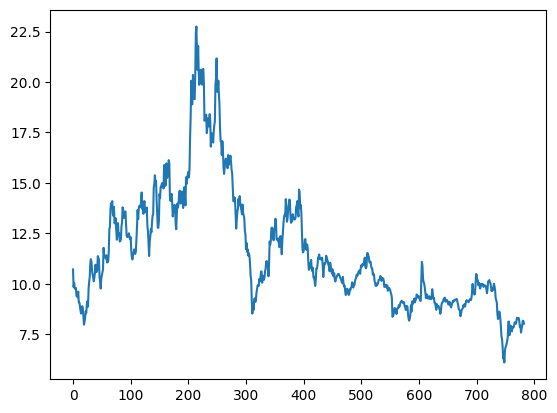

In [135]:
from matplotlib import pyplot as plt 
plt.plot(range(len(sdwd)),sdwd.loc[:,'close'])

In [121]:
mach_k.head(10)

,date,code,open,high,low,close,preclose,volume,amount,pbMRQ,peTTM,turn,tradestatus,pctChg,isST,p5_close,gap_5d,is_inc_5d
5,2021-01-11,sh.600028,4.19,4.19,4.05,4.06,4.19,247239526.0,1017312382.59,0.674113,12.998099,0.2587,1.0,-3.1026,0.0,4.03,0.007444,0
6,2021-01-12,sh.600028,4.06,4.15,4.05,4.15,4.06,146946494.0,603607780.56,0.689056,13.286234,0.1538,1.0,2.2167,0.0,4.02,0.032338,0
7,2021-01-13,sh.600028,4.16,4.25,4.14,4.22,4.15,228990675.0,961085593.05,0.700679,13.510339,0.2396,1.0,1.6867,0.0,4.11,0.026764,0
8,2021-01-14,sh.600028,4.21,4.28,4.18,4.23,4.22,191255566.0,808621150.88,0.70234,13.542354,0.2001,1.0,0.237,0.0,4.12,0.026699,0
9,2021-01-15,sh.600028,4.23,4.26,4.21,4.24,4.23,160722724.0,681091135.24,0.704,13.574369,0.1682,1.0,0.2364,0.0,4.19,0.011933,0
10,2021-01-18,sh.600028,4.2,4.21,4.14,4.16,4.24,201744129.0,839947933.11,0.690717,13.318249,0.2111,1.0,-1.8868,0.0,4.06,0.024631,0
11,2021-01-19,sh.600028,4.16,4.22,4.14,4.17,4.16,169801127.0,709264825.47,0.692377,13.350264,0.1777,1.0,0.2404,0.0,4.15,0.004819,0
12,2021-01-20,sh.600028,4.2,4.23,4.13,4.16,4.17,109734687.0,458308163.95,0.690717,13.318249,0.1148,1.0,-0.2398,0.0,4.22,-0.014218,0
13,2021-01-21,sh.600028,4.15,4.19,4.13,4.16,4.16,105716400.0,439944752.97,0.690717,13.318249,0.1106,1.0,0.0,0.0,4.23,-0.016548,0
14,2021-01-22,sh.600028,4.15,4.16,4.06,4.07,4.16,131965495.0,540403460.11,0.675773,13.030114,0.1381,1.0,-2.1635,0.0,4.24,-0.040094,0


In [166]:
pvt_mach = pd.pivot(mach_k,index=['date'],columns=['code'],values=['close'])

In [167]:
corr_mach = pvt_mach.corr()
from IPython.display import display
display(corr_mach)

close                                                    \
code            sh.600111 sh.600114 sh.600206 sh.600219 sh.600255 sh.600259   
      code                                                                    
close sh.600111  1.000000 -0.000203  0.633344  0.786778  0.402502  0.809085   
      sh.600114 -0.000203  1.000000 -0.197523 -0.066758 -0.132515 -0.058268   
      sh.600206  0.633344 -0.197523  1.000000  0.423615  0.612413  0.703196   
      sh.600219  0.786778 -0.066758  0.423615  1.000000  0.307469  0.666349   
      sh.600255  0.402502 -0.132515  0.612413  0.307469  1.000000  0.659825   
...                   ...       ...       ...       ...       ...       ...   
      sz.300855  0.822347 -0.195541  0.698053  0.669766  0.545211  0.754038   
      sz.300930  0.580481 -0.112633  0.655235  0.461480  0.712224  0.789559   
      sz.300963  0.530669 -0.337626  0.362405  0.758673  0.218332  0.475767   
      sz.300986  0.761980 -0.297729  0.542730  0.759188  0.523551  0.707868   
      sz.301026  0.894746 -0.106147  0.433798  0.923959  0.210585  0.690645   

                                                         ...            \
code            sh.600330 sh.600331 sh.600338 sh.600362  ... sz.300697   
      code                                               ...             
close sh.600111  0.724502 -0.060259  0.910067  0.309921  ...  0.065458   
      sh.600114  0.034826  0.655287 -0.070739 -0.088436  ... -0.096785   
      sh.600206  0.682479 -0.225623  0.733407 -0.057312  ... -0.095778   
      sh.600219  0.515373 -0.272343  0.688013  0.708541  ...  0.470094   
      sh.600255  0.615040 -0.361014  0.621922 -0.146713  ... -0.054734   
...                   ...       ...       ...       ...  ...       ...   
      sz.300855  0.820909 -0.388079  0.831034  0.159128  ...  0.014927   
      sz.300930  0.803166 -0.386481  0.704595  0.076041  ...  0.163678   
      sz.300963  0.320300 -0.563761  0.485784  0.767363  ...  0.720710   
      sz.300986  0.744836 -0.630025  0.772407  0.500660  ...  0.358830   
      sz.301026  0.592956 -0.243276  0.793176  0.832327  ...  0.702690   

                                                                             \
code            sz.300748 sz.300811 sz.300828 sz.300835 sz.300855 sz.300930   
      code                                                                    
close sh.600111  0.624431  0.548700  0.548808  0.631891  0.822347  0.580481   
      sh.600114 -0.283525 -0.156253 -0.129262 -0.016778 -0.195541 -0.112633   
      sh.600206  0.600875  0.643130  0.242265  0.276045  0.698053  0.655235   
      sh.600219  0.637513  0.312313  0.734458  0.746717  0.669766  0.461480   
      sh.600255  0.574408  0.649029  0.113910  0.247395  0.545211  0.712224   
...                   ...       ...       ...       ...       ...       ...   
      sz.300855  0.751507  0.753110  0.539680  0.631831  1.000000  0.674063   
      sz.300930  0.793225  0.653955  0.514183  0.562218  0.674063  1.000000   
      sz.300963  0.626724  0.234519  0.745479  0.648793  0.529361  0.416587   
      sz.300986  0.824838  0.615808  0.765214  0.824798  0.863961  0.634804   
      sz.301026  0.632242  0.364250  0.848008  0.813549  0.739055  0.458628   

                                               
code            sz.300963 sz.300986 sz.301026  
      code                                     
close sh.600111  0.530669  0.761980  0.894746  
      sh.600114 -0.337626 -0.297729 -0.106147  
      sh.600206  0.362405  0.542730  0.433798  
      sh.600219  0.758673  0.759188  0.923959  
      sh.600255  0.218332  0.523551  0.210585  
...                   ...       ...       ...  
      sz.300855  0.529361  0.863961  0.739055  
      sz.300930  0.416587  0.634804  0.458628  
      sz.300963  1.000000  0.765955  0.914466  
      sz.300986  0.765955  1.000000  0.779764  
      sz.301026  0.914466  0.779764  1.000000  

[135 rows x 135 columns]

In [168]:
corr_mach.loc[corr_mach.loc[:,('close','sz.002026')]< -0.5,('close','sz.002026')]

       code     
close  sh.600547   -0.524107
       sh.600766   -0.581894
       sz.000975   -0.622208
Name: (close, sz.002026), dtype: float64

### 使用神经网络预测未来5日增长的可能性

In [299]:
ts_cols = ['open','high','low','close','volume','amount','pbMRQ','peTTM','turn','pctChg']
sd_ts_features = sdwd.loc[:,ts_cols]
sd_cat_y = sdwd.loc[:,'is_inc_5d']
sd_ts_y = sdwd.loc[:,'gap_5d']

In [364]:
sd_cat_y[sd_cat_y==0].count()

1405

In [335]:
import random

sequence = random.shuffle(list(range(len(sd_cat_y))))
new_sd_cat_y= sd_cat_y[sequence]

In [300]:
#prepare k data of one stock
p_inc = np.nan_to_num(sd_cat_y.values.reshape((-1,)))
raw_data = np.nan_to_num(sd_ts_features.values)

In [455]:
#compute the number of samples we will use for each data split
num_train_samples = int(0.7*len(raw_data))
num_val_samples = int(0.2 * len(raw_data))
num_test_smaples = len(raw_data) - num_train_samples - num_val_samples

#normalize the data
meann = raw_data[:num_train_samples].mean(axis=0)
raw_data -= meann
stdd = raw_data[:num_train_samples].std(axis=0)
raw_data /= stdd



In [378]:
a = p_inc[num_train_samples + num_val_samples:]
len(a[a==1])/len(a)

0.03430079155672823

In [420]:
import keras
sequence_length = 120
batch_size = 64

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    shuffle = True,
    start_index = 0,
    end_index = num_train_samples
)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    shuffle = True,
    start_index = num_train_samples,
    end_index = num_train_samples + num_val_samples
)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    shuffle = False,
    start_index = num_train_samples + num_val_samples
)

In [323]:
for samples,targets in test_dataset:
    print('samples shape:',samples.shape)
    print("targets shape:",targets.shape)


samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (64, 120, 10)
targets shape: (64,)
samples shape: (4, 120, 10)
targets shape: (4,)


In [324]:
def evaluate_naive_method(dataset):
    total_abs_err = 0
    samples_seen = 0
    for samples,targets in dataset:
        preds = np.int64(samples[:,-1,1]*stdd[1] + meann[1])
        total_abs_err += np.sum(np.abs(preds-targets))
        samples_seen += samples.shape[0]

    return total_abs_err/samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 3.18
Test MAE: 0.72


In [337]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(64,activation = 'relu')(x)
outputs = layers.Dense(1,activation ='sigmoid')(x)
model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="jena_dense.h5", save_best_only=True)
]
model.compile(optimizer="rmsprop",loss="binary_crossentropy",metrics=["accuracy"])
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_dense.h5")
print(f"Test accuracy:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
10/10 [==============================] - 0s 11ms/step - loss: 0.3582 - accuracy: 0.8932 - val_loss: 1.0487 - val_accuracy: 0.6718
Epoch 2/30
10/10 [==============================] - 0s 6ms/step - loss: 0.1094 - accuracy: 0.9670 - val_loss: 1.3791 - val_accuracy: 0.8263
Epoch 3/30
10/10 [==============================] - 0s 6ms/step - loss: 0.1180 - accuracy: 0.9608 - val_loss: 0.5938 - val_accuracy: 0.7838
Epoch 4/30
10/10 [==============================] - 0s 7ms/step - loss: 0.0483 - accuracy: 0.9859 - val_loss: 3.4202 - val_accuracy: 0.1737
Epoch 5/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0577 - accuracy: 0.9796 - val_loss: 0.7445 - val_accuracy: 0.8147
Epoch 6/30
10/10 [==============================] - 0s 6ms/step - loss: 0.0586 - accuracy: 0.9827 - val_loss: 0.7575 - val_accuracy: 0.8108
Epoch 7/30
10/10 [==============================] - 0s 5ms/step - loss: 0.0179 - accuracy: 0.9937 - val_loss: 0.6999 - val_accuracy: 0.8185
Epoch 8/30
10/10 [=

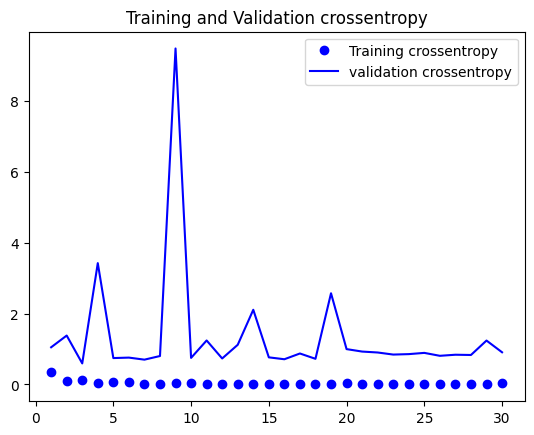

In [344]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training crossentropy")
plt.plot(epochs, val_loss, "b",label = "validation crossentropy")
plt.title("Training and Validation crossentropy")
plt.legend()
plt.show()

In [343]:
history.history['val_loss']

[1.04867422580719,
 1.3791319131851196,
 0.5937899351119995,
 3.4202463626861572,
 0.7445385456085205,
 0.7575154304504395,
 0.6999276280403137,
 0.8022811412811279,
 9.471312522888184,
 0.7496911287307739,
 1.2405916452407837,
 0.7333481311798096,
 1.1184781789779663,
 2.1057353019714355,
 0.764719545841217,
 0.7113015055656433,
 0.8736158609390259,
 0.7235629558563232,
 2.5709753036499023,
 0.9969539046287537,
 0.9278078675270081,
 0.9015820026397705,
 0.8431652188301086,
 0.8557344079017639,
 0.8906267881393433,
 0.8082861304283142,
 0.8384451270103455,
 0.8313828110694885,
 1.238244652748108,
 0.9078397750854492]

In [353]:
inputs = keras.Input(shape=(sequence_length,raw_data.shape[-1]))
x = layers.Conv1D(8,15,activation='relu')(inputs)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8,10,activation='relu')(x)
x = layers.MaxPool1D(2)(x)
x = layers.Conv1D(8,5,activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1,activation='sigmoid')(x)

model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",save_best_only=True)
]

model.compile(optimizer='rmsprop',loss="binary_crossentropy",metrics="accuracy")
tensorboard = keras.callbacks.TensorBoard(
        log_dir= '/Users/maxyang/Documents/Algo/stock_ts_log '
)
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.h5")
print(f"test accuracy: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
10/10 [==============================] - 0s 12ms/step - loss: 0.3973 - accuracy: 0.9074 - val_loss: 0.5332 - val_accuracy: 0.8263
Epoch 2/10
10/10 [==============================] - 0s 5ms/step - loss: 0.1559 - accuracy: 0.9608 - val_loss: 0.5678 - val_accuracy: 0.8263
Epoch 3/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.9576 - val_loss: 0.6081 - val_accuracy: 0.8263
Epoch 4/10


/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


10/10 [==============================] - 0s 6ms/step - loss: 0.1171 - accuracy: 0.9608 - val_loss: 0.7891 - val_accuracy: 0.1737
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1170 - accuracy: 0.9545 - val_loss: 0.6362 - val_accuracy: 0.7838
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1144 - accuracy: 0.9560 - val_loss: 0.7064 - val_accuracy: 0.5135
Epoch 7/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1118 - accuracy: 0.9513 - val_loss: 0.5796 - val_accuracy: 0.8185
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1103 - accuracy: 0.9560 - val_loss: 0.5418 - val_accuracy: 0.8263
Epoch 9/10
10/10 [==============================] - 0s 6ms/step - loss: 0.1083 - accuracy: 0.9513 - val_loss: 0.5381 - val_accuracy: 0.8263
Epoch 10/10
5/5 [==============================] - 0s 1ms/step - loss: 0.1659 - accuracy: 0.9692
test accuracy: 0.97


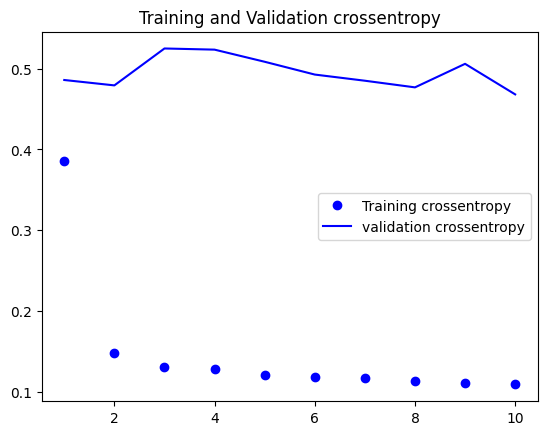

In [346]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training crossentropy")
plt.plot(epochs, val_loss, "b",label = "validation crossentropy")
plt.title("Training and Validation crossentropy")
plt.legend()
plt.show()

In [443]:
inputs = keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = layers.LSTM(64,return_sequences = True)(inputs)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.h5",
                                    save_best_only=True)
]
model.compile(optimizer=keras.optimizers.RMSprop(1e-2),loss="binary_crossentropy",metrics=["accuracy"])

history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.h5")
print(f"Test lstm accuracy:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30


ValueError: in user code:

    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1338, in train_function  *
        return step_function(self, iterator)
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1322, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1303, in run_step  **
        outputs = model.train_step(data)
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1081, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/training.py", line 1139, in compute_loss
        return self.compiled_loss(
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/losses.py", line 142, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/losses.py", line 268, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/losses.py", line 2432, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/Users/maxyang/miniconda3/envs/stockpy38/lib/python3.8/site-packages/keras/src/backend.py", line 5809, in binary_crossentropy
        return tf.nn.sigmoid_cross_entropy_with_logits(

    ValueError: `logits` and `labels` must have the same shape, received ((None, None, 1) vs (None,)).


In [454]:
class_weights = {0:1,1:10}
inputs = keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = layers.LSTM(64,recurrent_dropout=0.25,return_sequences=True)(inputs)
x = layers.LSTM(64,recurrent_dropout=0.25)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer=keras.optimizers.RMSprop(1e-2)
              ,loss="binary_crossentropy"
              ,metrics="accuracy"
              )
tensorboard = keras.callbacks.TensorBoard(
        log_dir= '/Users/maxyang/Documents/Algo/stock_ts_log',
)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",save_best_only=True)
    ,tensorboard
]
history = model.fit(train_dataset,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    ,class_weight=class_weights)
print(f"Test lstm accuracy:{model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/30
10/10 [==============================] - 3s 146ms/step - loss: 0.9303 - accuracy: 0.8509 - val_loss: 0.8550 - val_accuracy: 0.1737
Epoch 2/30
10/10 [==============================] - 1s 128ms/step - loss: 0.7051 - accuracy: 0.8524 - val_loss: 0.9775 - val_accuracy: 0.1737
Epoch 3/30
10/10 [==============================] - 1s 129ms/step - loss: 0.6827 - accuracy: 0.8666 - val_loss: 0.6144 - val_accuracy: 0.8263
Epoch 4/30
10/10 [==============================] - 1s 127ms/step - loss: 0.6616 - accuracy: 0.8289 - val_loss: 1.2269 - val_accuracy: 0.1737
Epoch 5/30
10/10 [==============================] - 1s 127ms/step - loss: 0.6543 - accuracy: 0.8854 - val_loss: 0.5103 - val_accuracy: 0.8263
Epoch 6/30
10/10 [==============================] - 1s 127ms/step - loss: 0.7004 - accuracy: 0.9058 - val_loss: 1.1234 - val_accuracy: 0.1737
Epoch 7/30
10/10 [==============================] - 1s 128ms/step - loss: 0.5843 - accuracy: 0.8932 - val_loss: 1.1209 - val_accuracy: 0.1737
Epoch 

In [ ]:

for x_batch, y_batch in train_dataset:
    train_data = train_dataset[i:i+window_size]
    val_data = train_dataset[i+window_size:i+window_size+step_size]
    X_train = train_data[:, :-1]
    y_train = train_data[:, -1]
    X_val = val_data[:, :-1]
    y_val = val_data[:, -1]

In [464]:
sequence_length = 261
batch_size = 64
step_size = 1

win_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data,
    targets = p_inc,
    sequence_length=sequence_length,
    batch_size = batch_size,
    step_size = step_size,
    start_index = 0,
    shuffle = False
    
)

TypeError: timeseries_dataset_from_array() got an unexpected keyword argument 'step_size'

In [462]:
class_weights = {0:1,1:10}
inputs = keras.Input(shape = (sequence_length,raw_data.shape[-1]))
x = layers.LSTM(64,recurrent_dropout=0.25,return_sequences=True)(inputs)
x = layers.LSTM(64,recurrent_dropout=0.25)(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1,activation='sigmoid')(x)
model = keras.Model(inputs,outputs)
model.compile(optimizer=keras.optimizers.RMSprop(1e-2)
              ,loss="binary_crossentropy"
              ,metrics="accuracy"
              )
tensorboard = keras.callbacks.TensorBoard(
        log_dir= '/Users/maxyang/Documents/Algo/stock_ts_log',
)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.h5",save_best_only=True)
    ,tensorboard
]


In [463]:
from sklearn.metrics import accuracy_score
for x_batch, y_batch in win_dataset:
    train_data = x_batch[:-1,:]
    val_data = x_batch[-1,:]
    train_y = y_batch[:-1]
    val_y = y_batch[-1]

    model.fit(train_data, train_y,
                    epochs=30,
                    validation_data=val_dataset,
                    callbacks=callbacks
                    ,class_weight=class_weights)
    
    acc = accuracy_score(val_data, val_y)
    print(f"Test lstm accuracy:{acc:.2f}")

NameError: name 'win_dataset' is not defined

In [438]:
pred_l =[]
act_l = []
for x_batch,y_batch in test_dataset:
    # 使用模型进行预测
    predictions = model.predict(x_batch)
    pred = predictions.flatten()
    pred_temp = pd.Series(pred)
    # 打印预测结果
    pred_l.append(pred_temp)
    act_l.append(pd.Series(y_batch))
pred_s = pd.concat(pred_l,axis=0,ignore_index=True)
act_s = pd.concat(act_l,axis=0,ignore_index=True)

1/1 [==============================] - 0s 12ms/step


In [439]:

pred_s[pred_s>0.5]=1
pred_s[pred_s<=0.5]=0

In [440]:
#act_s = pd.Series(sd_cat_y[num_train_samples + num_val_samples:]).reset_index(drop=True)
df = pd.concat([pred_s,act_s],axis=1,ignore_index=True)
df.columns = ['pred','act']
df.loc[:,'gap']= abs(df.loc[:,'pred']-df.loc[:,'act'])

In [441]:
df

,pred,act,gap
0,1.0,0,1.0
1,1.0,0,1.0
2,1.0,0,1.0
3,1.0,0,1.0
4,1.0,0,1.0
...,...,...,...
255,0.0,0,0.0
256,0.0,0,0.0
257,0.0,0,0.0
258,0.0,0,0.0


In [ ]:
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)

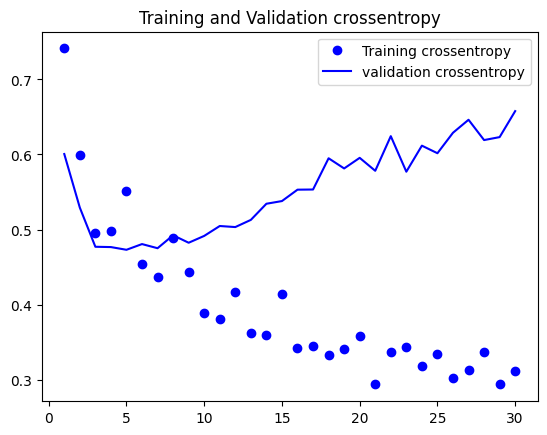

In [407]:
import matplotlib.pyplot as plt
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1,len(loss)+1)
plt.figure()
plt.plot(epochs,loss,"bo",label="Training crossentropy")
plt.plot(epochs, val_loss, "b",label = "validation crossentropy")
plt.title("Training and Validation crossentropy")
plt.legend()
plt.show()